# Sequential Bayesian Learning (SBL)
## Authors:  Author: Robert Tjarko Lange, Miro Grundei, Sam Gjisem
## Last Update: December 2018

# 0. General Introduction to the project

In this project we investigate the theoretical modelling of mismatch-negativity in the human somatosensory cortex. More specifically, we study a novel roving paradigm which is generated from a structured graphical model. This allows us to define standard and deviant stimuli in stimulus-feature-independent manner. Furthermore, sampling (as opposed to deterministic sequence generation) enables us to control for sequence-dependent cofounding factors.

The following notebook is structured as follows:

- **1. Generation of Trial Sequences based on Graphical Model**
    * We formulate a general Markov model which generates a sequence of trials (0 - low intensity, 0.5 - catch trial, 1 - high intensity)
    * The alternation probability between different observations depends upon the previous observed states as well as the hidden state/regime which is modeled as a Markov Chain.
    * We are able to increase the order of the Markov dependency in the data-generating process. This allows to vary the complexity of the sequence generation.
    
    
- **2. Modeling of different Sequential Bayesian Learning Agents**.
    * The agents process the trial sequence as it comes in. Based on different probabilistic models they update there current posterior estimate about the hidden state that drives the sampling of the observed state. 
    * Based on her current posterior estimate, we can calculate different surprise measures (e.g. Predictive, Bayesian as well as Confidence-Corrected). These surprise measures indicate how well the agent is able to infer the data-generating mechanism and the corresponding hidden states.
    * Going forward we will combine the data-generating paradigm and surprise measures with frequency data obtained from an EEG study. Thereby, we will be able to compare different models with different degrees of complexity of somatosensory adaptation and learning.
    
    
- **3. Model Comparison across Different SBL Agents and Surprise Regressors**
    * Evaluation of theoretical models in explaining the EEG frequency variation.

In [ ]:
!pip install -r requirements.txt --quiet

In [1]:
# Import relevant sampling modules
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import time
import numpy as np
import logging

import pymc3 as pm
import theano
import matplotlib.pyplot as plt

from utils.helpers import *
from utils.plotting import *
from utils.glm_models import *

import sampling.seq_gen as sg
import sampling.seq_analysis as sa

# Import relevant SBL modules
import sbl_agents.sbl_cat_dir as sbl_cd
import sbl_agents.sbl_hmm as sbl_hmm

# Set random seed for replicability and define directories
np.random.seed(seed=1234)
results_dir = os.getcwd() + "/results/"
fig_dir = os.getcwd() + "/figures/"
data_dir = os.getcwd() + "/data/"

# 1. Generation of Trial Sequence based on Graphical Model

Our sampling paradigm is motivated by the classical roving paradigm. In such a setting a deviant is defined relative to the previous trials.

Depending on whether or not we account for second order Markov dependency also $o_{t-2}$ influences the sampling probabilities. Our generating process can be described by the following graphical model:

<img src="figures/gm_seq_gen.png" alt="drawing" width="750"/>

* Catch: $p(o_t = 0.5) = 0.05$
* Regime switch: $p(s_t \neq s_{t-1}) = 0.01$

Sample a sequence from the Graphical Model and saves it to .mat file
* 1st order Markov sequence of length 800 with following probabilities:
    * Regime 0: $p(o_t = 0|o_{t-1}=0, s_t=0), p(o_t = 1|o_{t-1}=0, s_t=0)$
    * Regime 1: $p(o_t = 0|o_{t-1}=0, s_t=1), p(o_t = 1|o_{t-1}=0, s_t=1)$
```
pythonw seq_gen.py -t 1st_temp -reg_init 0.5 -reg_change 0.01 -catch 0.05 -obs_init 0.5 -obs_change 0.35 0.65 0.65 0.35 -order 1 -v -seq
800
```

* 2nd order Markov sequence of length 800 with following probabilities:
    * Regime 0: $p(o_t = 0|o_{t-1}=0, o_{t-1}=0) = 0.35, p(o_t|o_{t-1}) = 0.65$
    * Regime 1: $p(o_t = 0|o_{t-1}=0) = 0.65, p(o_t|o_{t-1}) = 0.35$
```
pythonw seq_gen.py -t 1st_temp -reg_init 0.5 -reg_change 0.01 -catch 0.05 -obs_init 0.5 -obs_change 0.35 0.65 0.65 0.35 -order 2 -v -seq
800
```

In [3]:
# Define parameters for sequence sampling
prob_regime_init = np.array([0.5, 0.5])  # Prob. vector for inital regime (hidden state)
prob_regime_change = 0.01  # Prob. of sampling a regime change
prob_obs_init = np.array([0.5, 0.5, 0])  # Prob. vector for inital trial/stimulus (observed state)
prob_obs_change = [0.45, 0.45, 0.05, 0.05, 0.05, 0.05, 0.45, 0.45]  # Prob. matrix for different regimes
prob_catch = 0.05  # Prob. of sampling a catch trial (independent of hidden state)

order = len(prob_obs_change)/4  # Markov order/lag dependency in the sampling scheme
seq_length = 200  # Length of sampled sequence
sample_file = "S1_200"  # Title of file saved
matlab_out = True  # Boolean - store file as .mat - otherwise .pkl file
plot_seq = True  # Booelean - plot the sampled sequence
verbose = True  # Print out the transition prob. specification and empirical statistics of the sampled seq
plot_seqs = False

In [4]:
# Create instance of sampling class
gen_temp = sg.seq_gen(order, prob_catch, prob_regime_init, prob_regime_change,
                      prob_obs_init, prob_obs_change, verbose)

All input arrays conform with the specified dimensions.
HHMM correctly initialized. Ready to Sample.
--------------------------------------------
2nd Order Transition Prob. 
 Regime 0: p(0|00)=0.45, p(0|01)=0.45, p(0|10)=0.05,  p(0|11)=0.05 
 Regime 1: p(0|00)=0.05, p(0|01)=0.05, p(0|10)=0.45,  p(0|11)=0.45
--------------------------------------------


Empirical Probabilities: 
 Empirical Catch Prob.: 0.05 
 Empirical Regime Switch Prob.: 0.03 
 Empirical Overall High-Intensity Stimulus Prob.: 0.7315789473684211 
 Empirical Regime 0 High-Intensity Stimulus Prob.: 0.8823529411764706 
 Empirical Regime 1 High-Intensity Stimulus Prob.: 0.6987179487179487 
 Empirical Regime 0 Alternation Prob.: 0.17142857142857143 
 Empirical Regime 1 Alternation Prob.: 0.6129032258064516  
 JS Div. Deviant Waiting Time Distr. between Regimes: 0.1806302059206959 
 Time in Regime 0: 0.175 
 Average Train Length in Regime 0: 3.7777777777777777 
 Average Train Length in Regime 1: 1.6082474226804124
--------------------------------------------


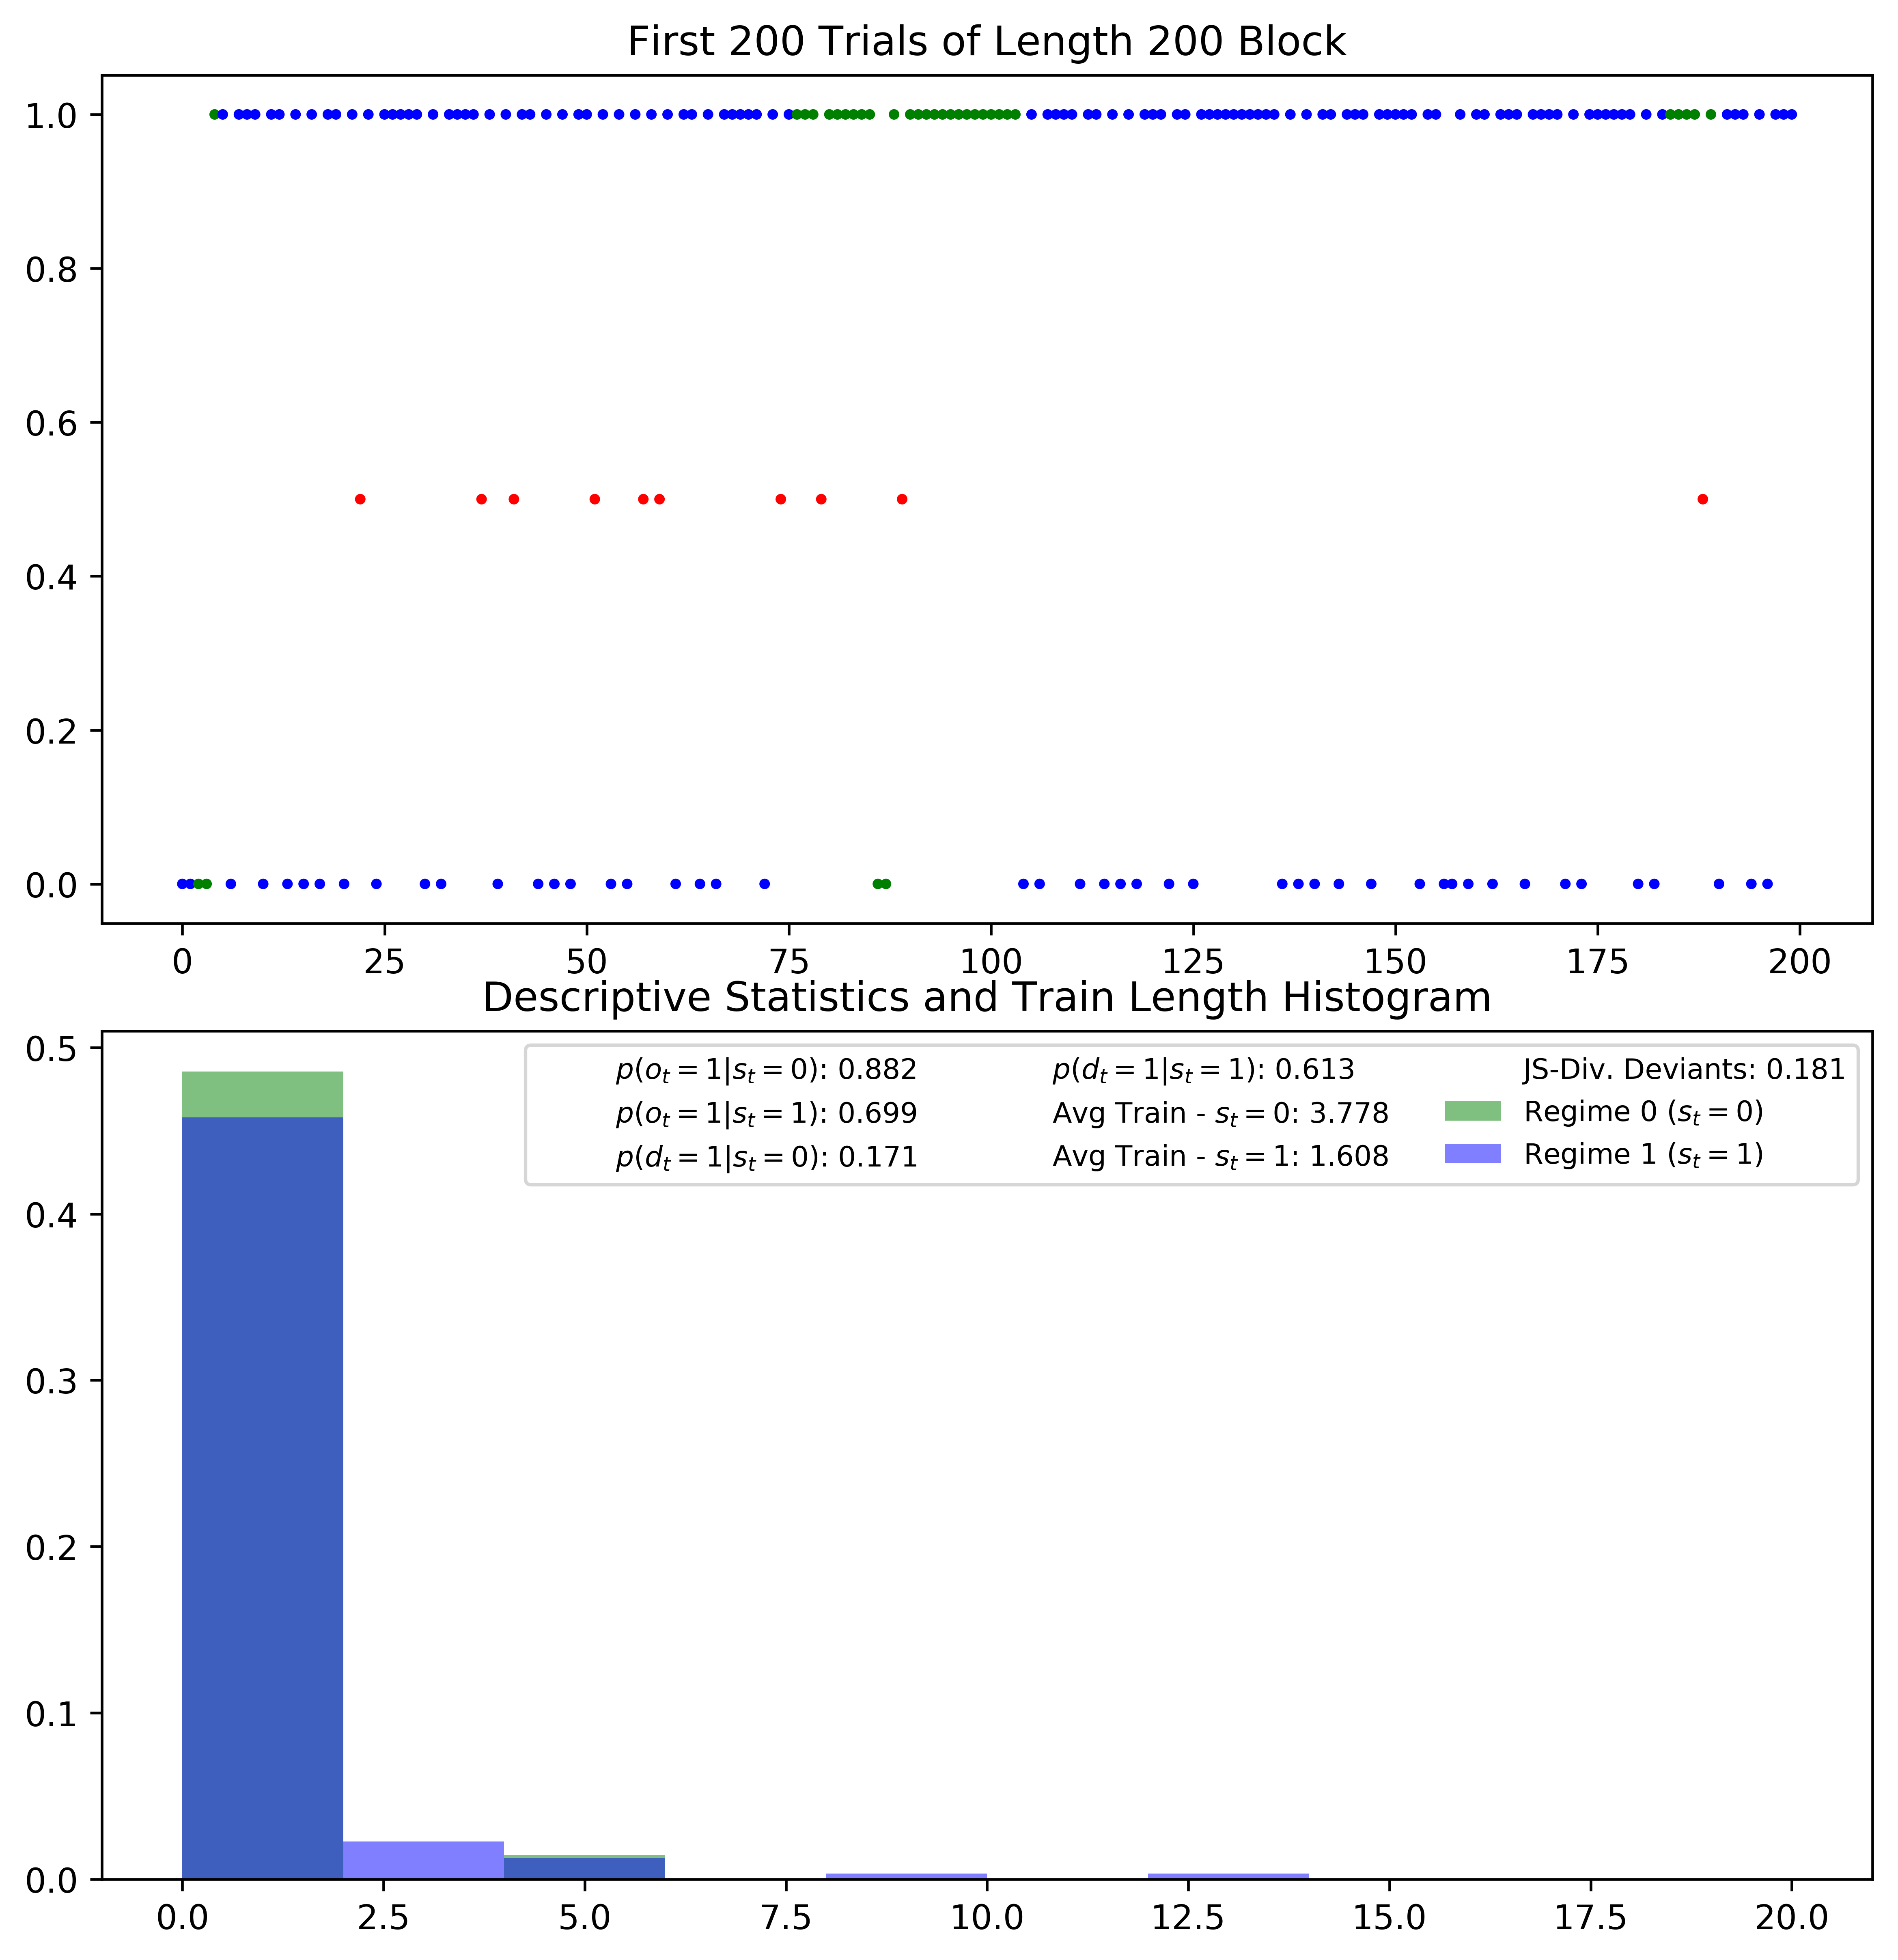

In [5]:
# sequence = gen_temp.sample(seq_length)
# Plot the sampled sequence - when exec from command line
sg.sample_and_save(gen_temp, seq_length, sample_file,
                   matlab_out, plot_seq)

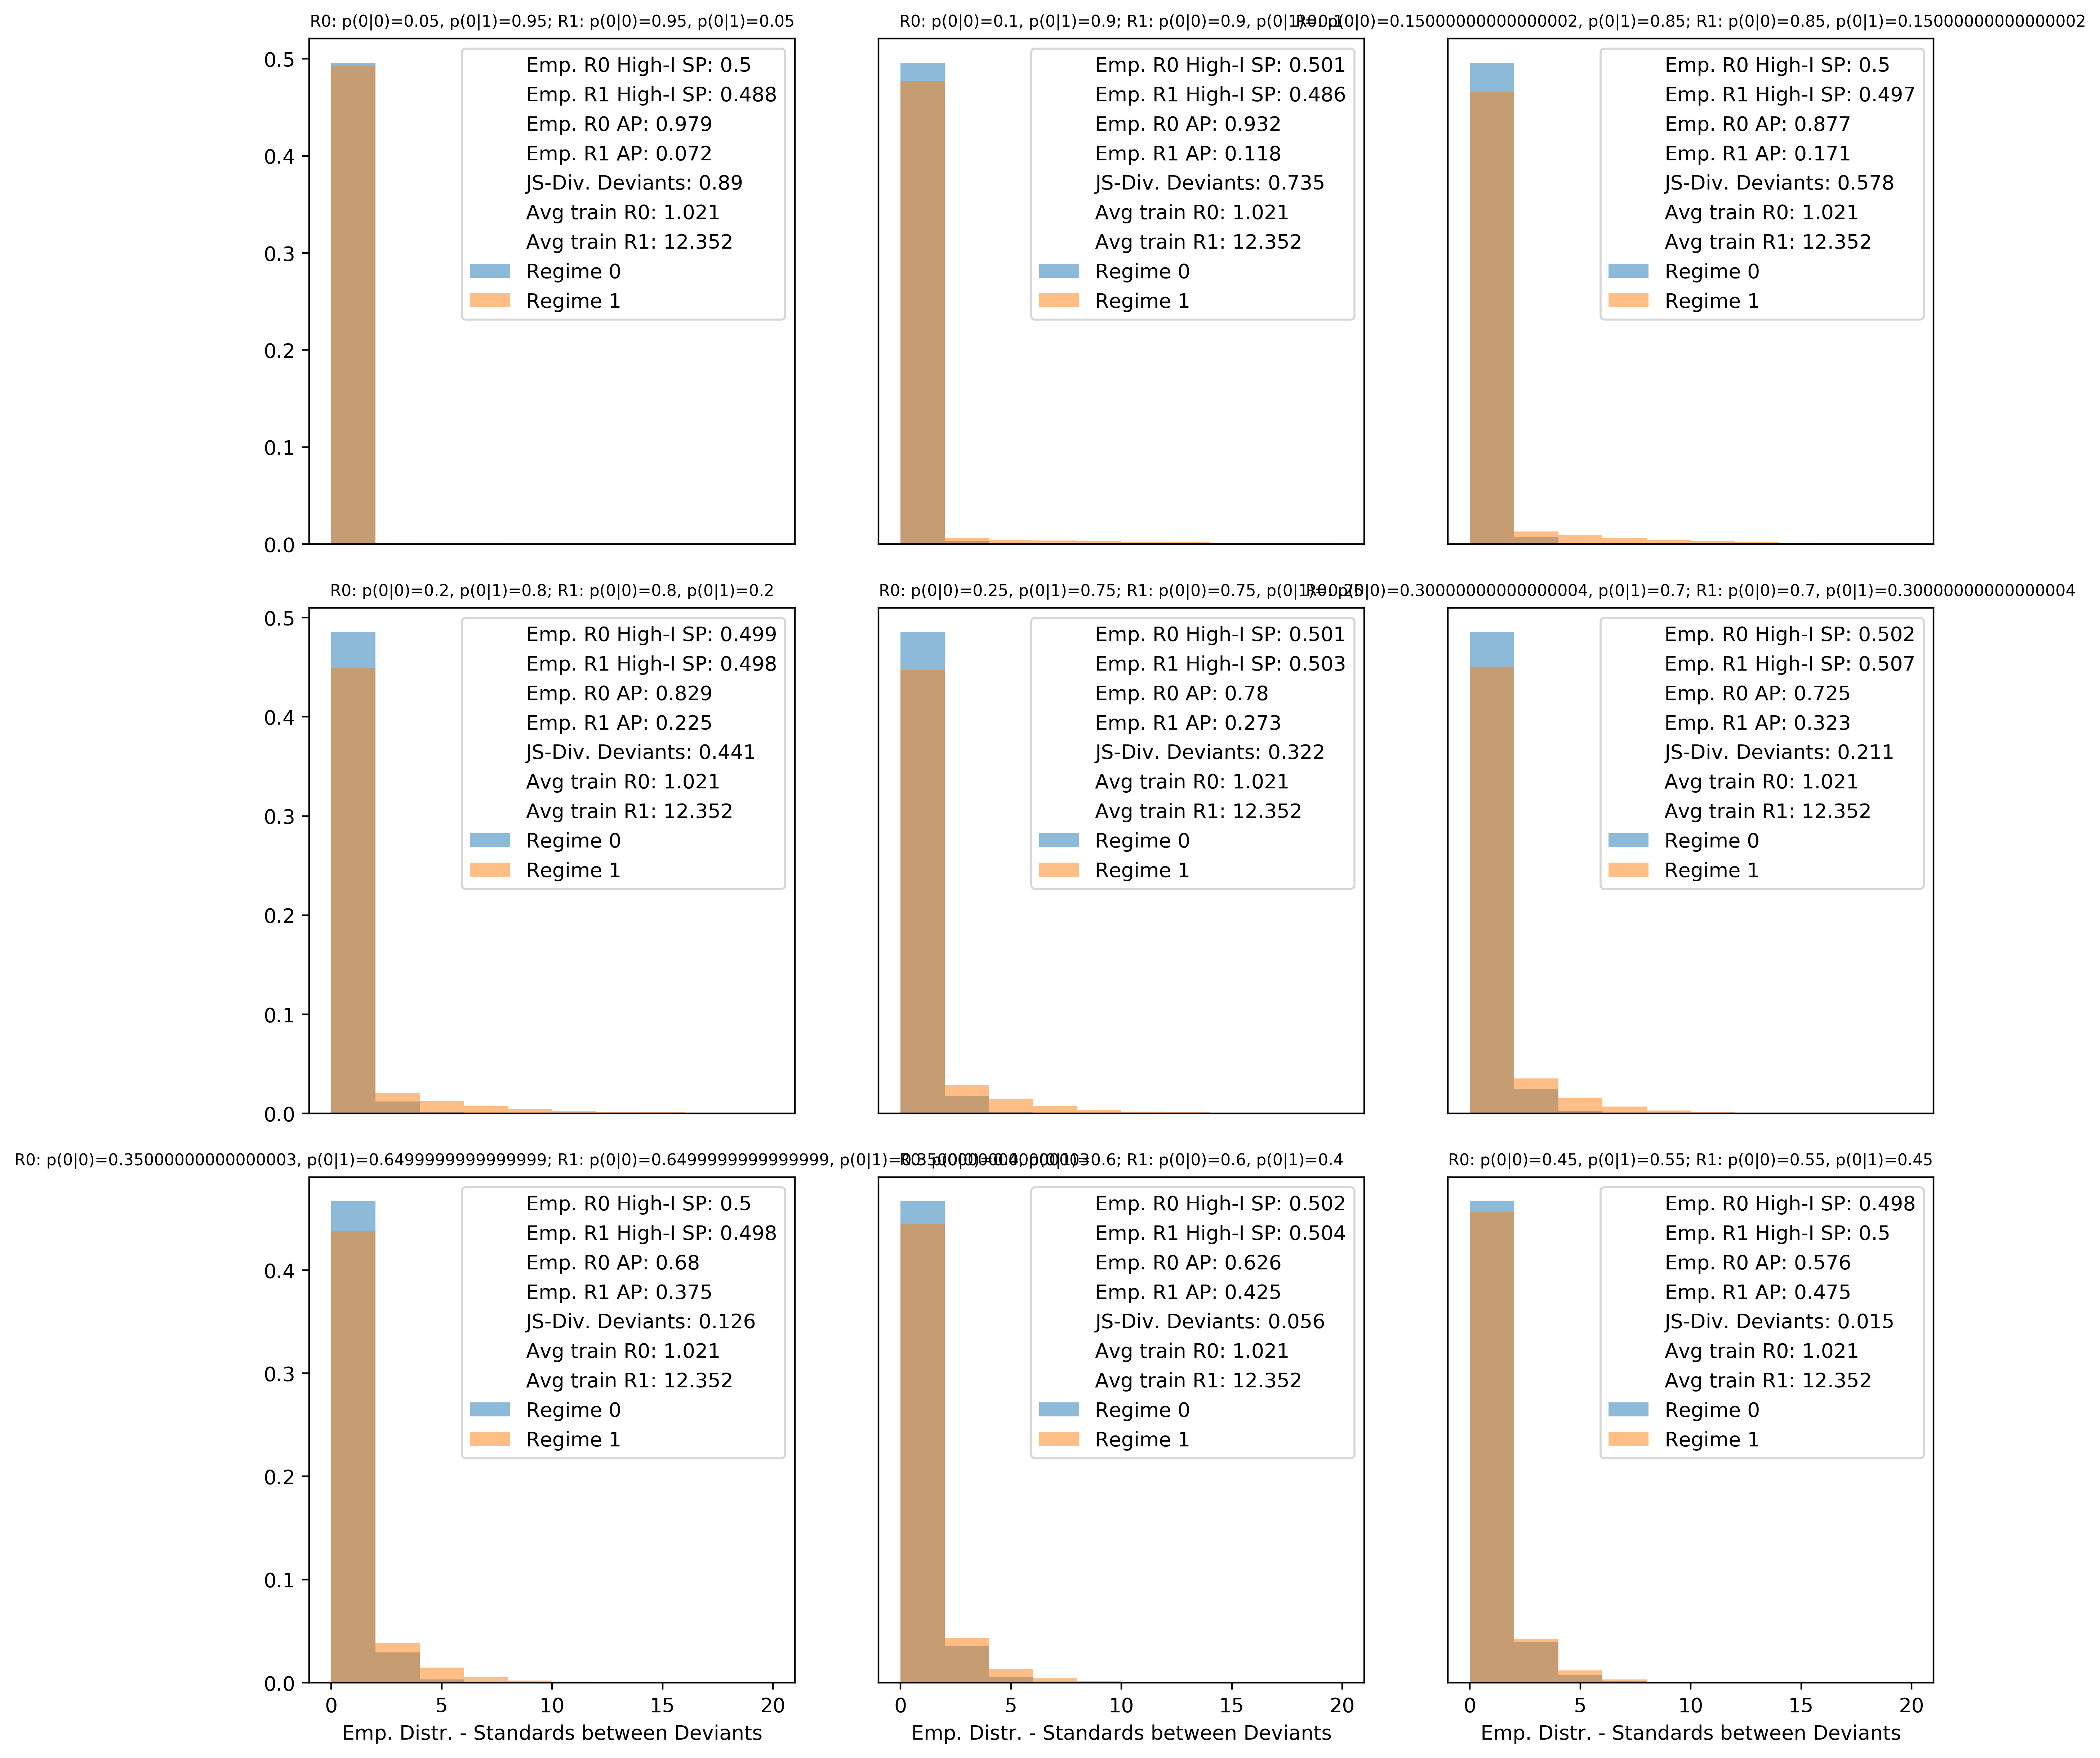

In [6]:
if plot_seqs:
    sa.main(order=1, verbose=False, plot=True, save=False)

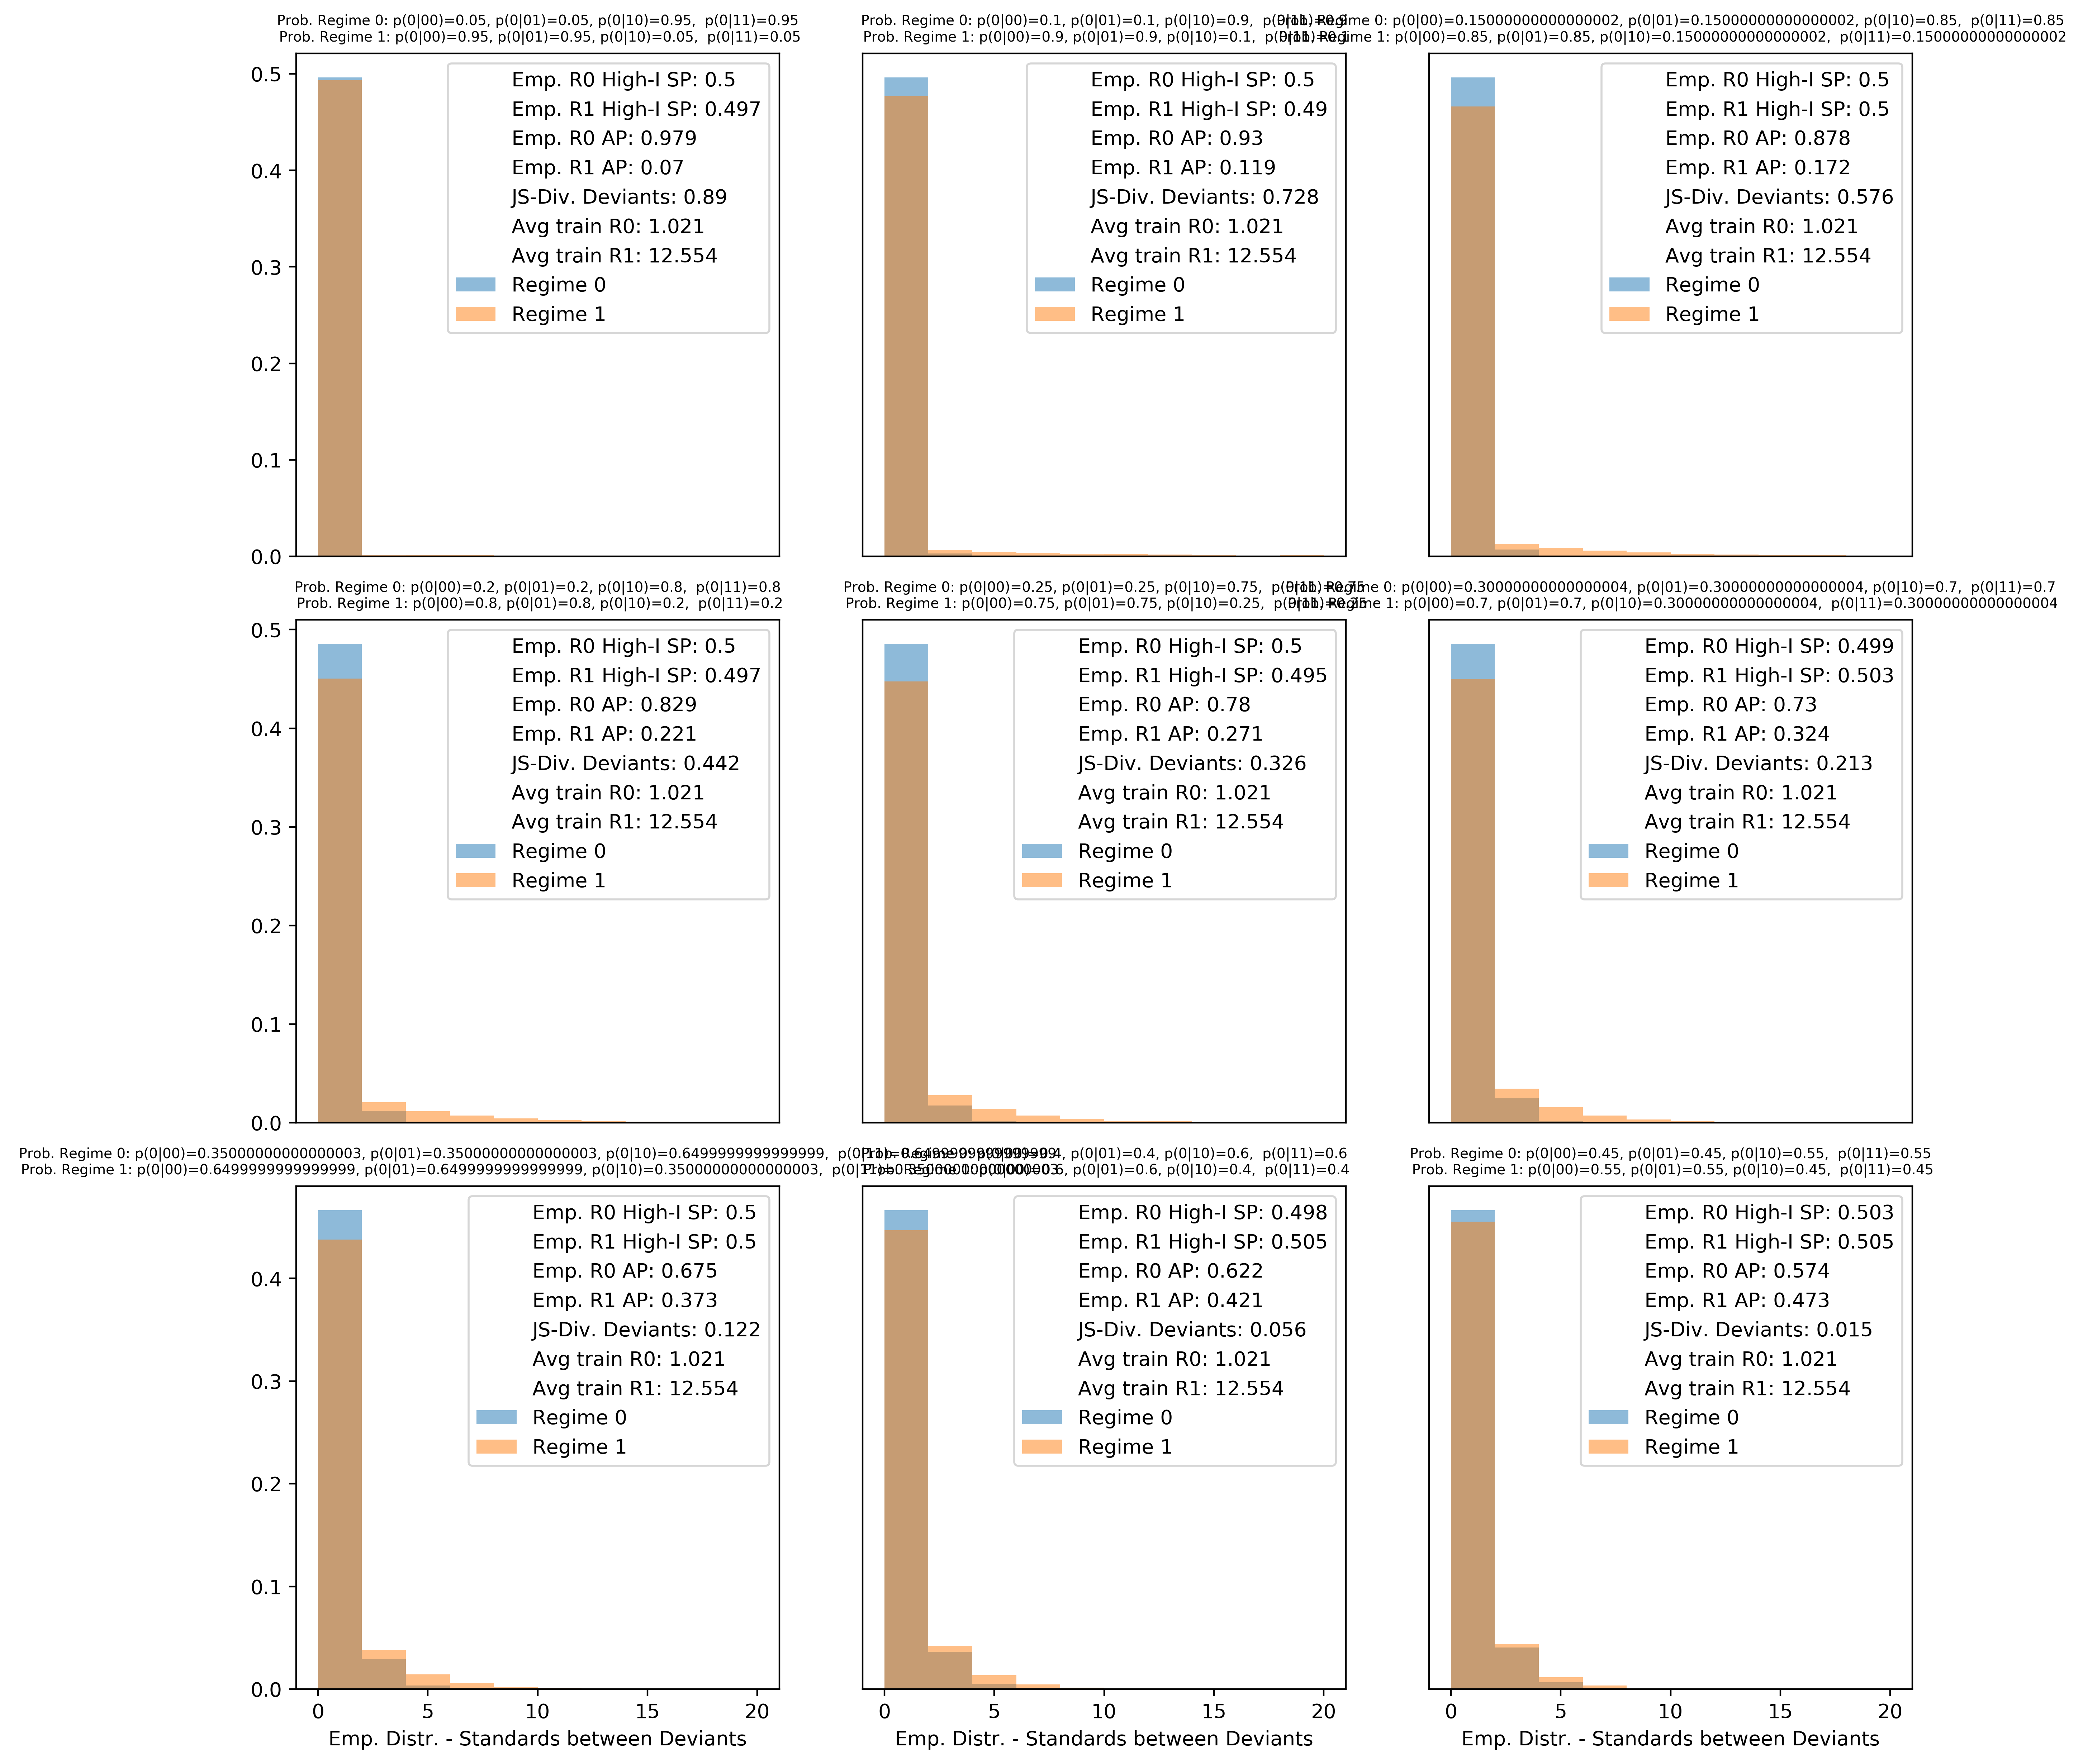

In [7]:
if plot_seqs:
    sa.main(order=2, verbose=False, plot=True, save=False)

# 2. Modeling of different Sequential Bayesian Learning Agents

In [8]:
sample_files = [["sub-01/sub-01_ses-1_run-1", "sub-01/sub-01_ses-1_run-2",
                 "sub-01/sub-01_ses-1_run-3", "sub-01/sub-01_ses-1_run-4",
                 "sub-01/sub-01_ses-1_run-5"]]

In [9]:
sample, meta = load_obj("data/" + sample_files[0][0] + ".mat")

seq = sample[:, 2]
hidden = sample[:, 1]

prob_regime_init = meta["prob_regime_init"]
prob_obs_init = meta["prob_obs_init"]
prob_obs_change = meta["prob_obs_change"]
prob_regime_change = meta["prob_regime_change"]

In [10]:
# General Model Settings
model_types = ["SP", "AP", "TP"]
save_results = True
verbose = True

## 2.1. Conjugate Categorical-Dirichlet Model

In [11]:
tau = 0.

In [12]:
# Test agents by calculating posterior after 3 timesteps
# and Surprises for t=1,2,3
for model in model_types:
    sbl_cd.test_agent(seq, hidden, tau, model, verbose)

---------------------------------------------
SP: Dirichlet-Distribution after 3 timestep: alphas = [3. 2. 1.]
SP: Computing different surprisal measures for 3 timesteps.
SP - t=1: PS=0.6931, BS=0.2359, CS=2.6146
SP - t=2: PS=0.5108, BS=0.1402, CS=3.9198
SP - t=3: PS=1.0986, BS=0.4739, CS=5.1507
SP: Done computing surprisal measures for all 800 timesteps.
---------------------------------------------
AP: Dirichlet-Distribution after 3 timestep: alphas = [2. 3.]
AP: Computing different surprisal measures for 3 timesteps.
AP - t=1: PS=0.6931, BS=0.2349, CS=0.2416
AP - t=2: PS=0.6931, BS=0.2082, CS=1.2224
AP - t=3: PS=0.9163, BS=0.1402, CS=1.807
AP: Done computing surprisal measures for all 800 timesteps.
---------------------------------------------
TP: Dirichlet-Distribution after 3 timestep: alphas = [[2. 2. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
TP: Computing different surprisal measures for 3 timesteps.
TP - t=1: PS=1.0986, BS=0.6419, CS=5.5487
TP - t=2: PS=0.6931, BS=0.5206, CS=7.1045
TP - t=

In [13]:
for model in model_types:
    sbl_cd.main(seq, hidden, tau, model,
                prob_regime_init, prob_obs_init, prob_obs_change,
                prob_regime_change,
                save_results, title="CD_" + model + "_" + sample_file,
                verbose=False)

Saved in File: /Users/rtl/Dropbox/PHD_ECN/LAB_ROTATION_1_BLANKENBURG/CODE/SBL/results/CD_SP_S1_200
Saved in File: /Users/rtl/Dropbox/PHD_ECN/LAB_ROTATION_1_BLANKENBURG/CODE/SBL/results/CD_AP_S1_200
Saved in File: /Users/rtl/Dropbox/PHD_ECN/LAB_ROTATION_1_BLANKENBURG/CODE/SBL/results/CD_TP_S1_200


In [14]:
SP_CD = load_obj(results_dir + "CD_" + "SP" + "_" + sample_file + ".pkl")
AP_CD = load_obj(results_dir + "CD_" + "AP" + "_" + sample_file + ".pkl")
TP_CD = load_obj(results_dir + "CD_" + "TP" + "_" + sample_file + ".pkl")

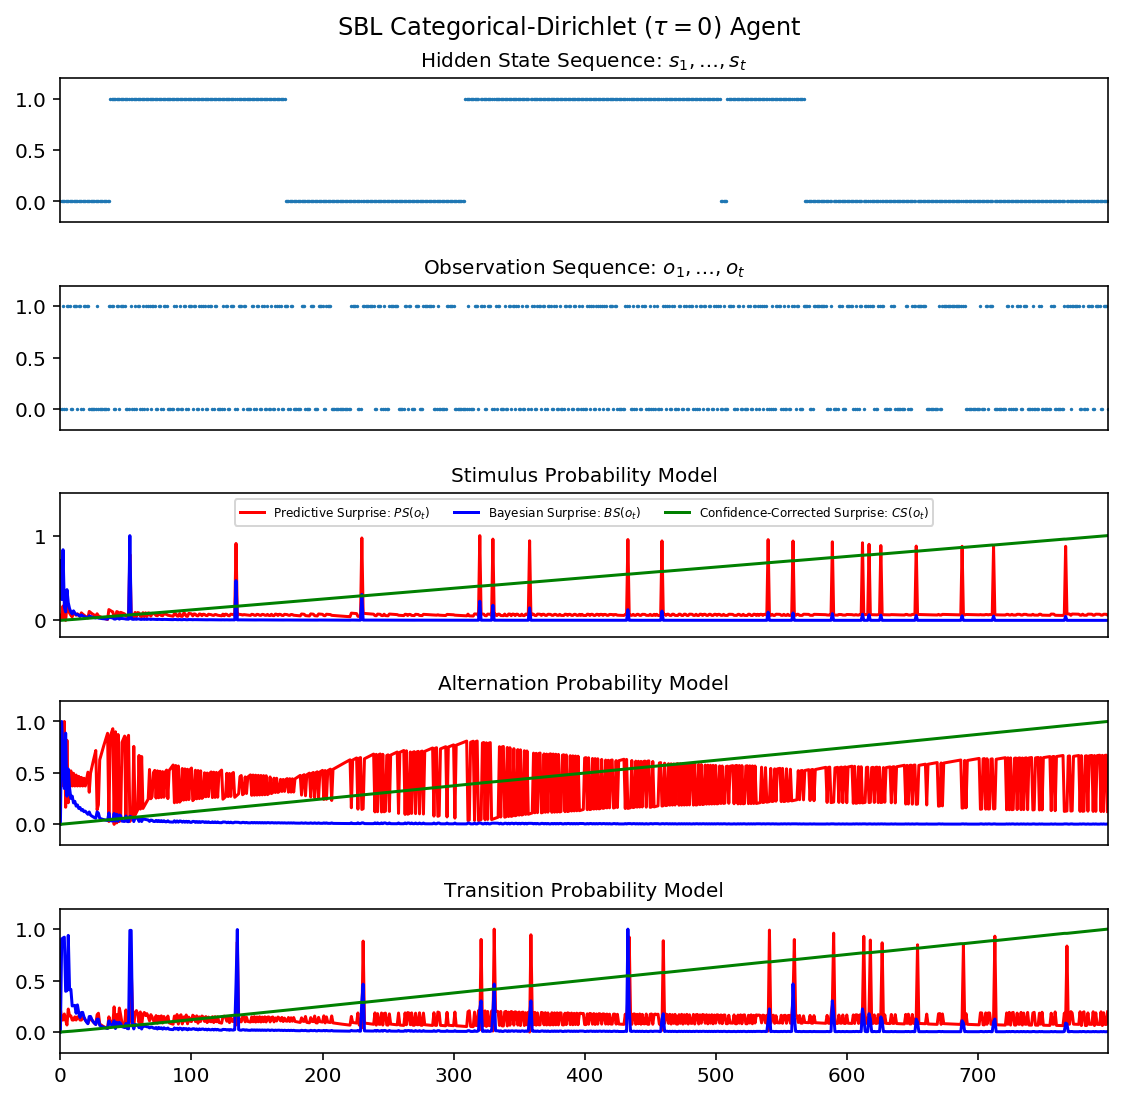

In [15]:
plot_surprise(SP_CD, AP_CD, TP_CD,
              title=r"Categorical-Dirichlet ($\tau = 0$)",
              save_pic=False)

## 2.2. Hidden Markov Model

In [ ]:
n_states = 2

In [ ]:
# Test agents by calculating posterior after 3 timesteps
# and Surprises for t=1,2,3
for model in model_types:
    sbl_hmm.test_agent(seq, hidden, n_states, model, verbose)

## 3. Model Comparison across Different SBL Agents and Surprise Regressors

In [16]:
sample_files = [["sub-01/sub-01_ses-1_run-1", "sub-01/sub-01_ses-1_run-2",
                 "sub-01/sub-01_ses-1_run-3", "sub-01/sub-01_ses-1_run-4",
                 "sub-01/sub-01_ses-1_run-5"]]

subject_list = range(len(sample_files))

# Load in EEG Dataset
eeg_files = ["sub-01/sub-01_sbl"]
eeg_data = sio.loadmat("data/" + eeg_files[0] + ".mat")

electrodes_of_interest = {"FCz": 47, "FC2": 46, "FC4": 45, 
                          "Cz": 48, "C2": 49, "C4": 50,
                          "C6": 51, "CPz": 32, "CP2": 56,
                          "CP4": 55, "CP6": 54}

trial_coding_lookup = {11: "First Regime - Low Intensity",
                       12: "First Regime - High Intensity",
                       21: "Second Regime - Low Intensity",
                       22: "Second Regime - High Intensity",
                       33: "Catch Trial"}

# Select block and electrode for analysis
subject_id = 0
block_id = 0
elec_id = electrodes_of_interest["FCz"]
sampling_rate = 0.3
inter_stim_interval = np.array([-0.05, 0.65])

In [17]:
# Get Regressors ready!
sample, meta = load_obj("data/" + sample_files[subject_id][block_id] + ".mat")
seq, hidden = sample[:, 2], sample[:, 1] 

In [18]:
# Compute Surprise Regressors
PS_SP, BS_SP, CS_SP = sbl_cd.main(seq, hidden, tau=0, model_type="SP")
PS_AP, BS_AP, CS_AP = sbl_cd.main(seq, hidden, tau=0, model_type="AP")
PS_TP, BS_TP, CS_TP = sbl_cd.main(seq, hidden, tau=0, model_type="TP")

regressors = {"PS_SP": PS_SP, "BS_SP": BS_SP, "CS_SP": CS_SP,
              "PS_AP": PS_AP, "BS_AP": BS_AP, "CS_AP": CS_AP,
              "PS_TP": PS_TP, "BS_TP": BS_TP, "CS_TP": CS_TP}

In [19]:
# Preprocessor data to get data that we want to explain by the surprise regressors
# Return an array of shape num_trials x sampling rate
y_elec = get_electrode_data(eeg_data, block_id, elec_id, inter_stim_interval, sampling_rate)

Done selecting block and electrode specific data for [-0.05, 0.65]ms interval
Downsampled original 512 Hz Sampling Rate to 152 Hz.


In [20]:
# Run Bayesian Ridge Regression with Half-Cauchy prior on likelihood sd (robust)
%time lme_ols = run_model_estimation(10, y_elec, PS_AP, "OLS")
print("LME for 10th Sample - Bayesian GLM with PS for AP: {}""".format(lme_ols[-1]))

CPU times: user 5.59 s, sys: 515 ms, total: 6.11 s
Wall time: 12.5 s
LME for 10th Sample - Bayesian GLM with PS for AP: 629.0530758108102


In [21]:
# Run Bayesian Hierarchical Regression
%time lme_hierarchical = run_model_estimation(10, y_elec, PS_AP, "Hierarchical")
print("LME for 10th Sample - Hierarchical GLM with PS for AP: {}""".format(lme_hierarchical[-1]))

CPU times: user 7.91 s, sys: 111 ms, total: 8.02 s
Wall time: 8.12 s
LME for 10th Sample - Hierarchical GLM with PS for AP: 618.0402221679688


In [22]:
# Run Bayesian MLP with 10 Hidden Units
%time lme_bayes_nn = run_model_estimation(10, y_elec, PS_AP, "Bayesian-MLP")
print("LME for 10th Sample - Bayesian NN with PS for AP: {}""".format(lme_bayes_nn[-1]))

CPU times: user 1min 55s, sys: 233 ms, total: 1min 56s
Wall time: 31.1 s
LME for 10th Sample - Bayesian NN with PS for AP: -1525.2406406080165


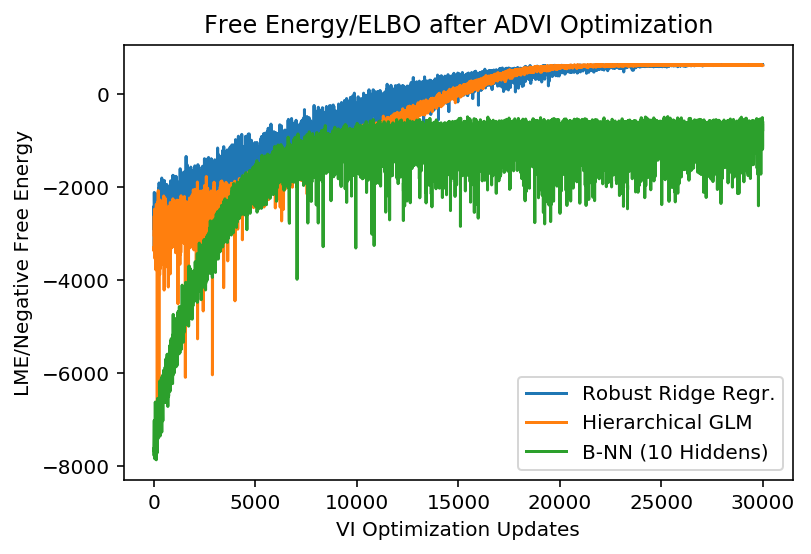

In [23]:
plot_free_energy([lme_ols, lme_hierarchical, lme_bayes_nn])

## 3.1 - Run Models in Parallel
### Loops to Run in computation
- 20 Subjects, 10 Electrodes
- 5 blocks, 10 Different Models, 332 Sample Point per event

In [ ]:
import multiprocessing
from functools import partial
from contextlib import contextmanager

np.random.seed(20)
    
def parallelize_over_samples(y_elec, regressor, model_type):    
    func = partial(run_model_estimation, y_elec=y_elec,
                   surprise_reg=regressor, model_type=model_type)
    
    sample_id = np.arange(y_elec.shape[1]).tolist()
    start = time.time()
    num_cpus = multiprocessing.cpu_count()

    with multiprocessing.Pool(processes=num_cpus-1) as pool:
        results = pool.map(func, sample_id)
    print("Done with {} samples in secs {}".format(y_elec.shape[1], time.time() - start))

    pool.close()
    pool.join()
    return results

In [ ]:
parallelize_over_samples(y_elec, PS_AP, "OLS")

In [ ]:
for subject_id in subject_list:
    print("Subject {}: LME Trial-by-Trial Analysis".format(subject_id))
    eeg_data = sio.loadmat("data/" + eeg_files[subject_id] + ".mat")
    for block_id, block_fname in enumerate(sample_files):
        print("\t Block {}: Load Seq, Comp Regressors, Load EEG")
        # Load in the specific trial/stimuli sequence
        sample, meta = load_obj("data/" + sample_files[subject_id][block_id] + ".mat")
        seq, hidden = sample[:, 2], sample[:, 1]
        # Compute Surprise Regressors
        PS_SP, BS_SP, CS_SP = sbl_cd.main(seq, hidden, tau=0, model_type="SP")
        PS_AP, BS_AP, CS_AP = sbl_cd.main(seq, hidden, tau=0, model_type="AP")
        PS_TP, BS_TP, CS_TP = sbl_cd.main(seq, hidden, tau=0, model_type="TP")

        regressors = {"PS-SP": PS_SP, "BS-SP": BS_SP, "CS-SP": CS_SP,
                      "PS-AP": PS_AP, "BS-AP": BS_AP, "CS-AP": CS_AP,
                      "PS-TP": PS_TP, "BS-TP": BS_TP, "CS-TP": CS_TP}
        
        # Get the block- and electrode-specific eeg data
        y_elec = get_electrode_data(eeg_data, block_id, elec_id,
                                    inter_stim_interval, sampling_rate)
        
        for model_type, reg in regressors.items():
            print("\t \t Model {}: Run in Parallel".format(model_type))

In [ ]:
plt.plot(y_elec[:, 200])
plt.title("Raw FCz Electrode Amplitude at Trial Time")

In [ ]:
template = "{} Block | {} GLM Model | Free Energy: {} | Time: {}"

log_model_evidences = {"PS_SP": [], "BS_SP": [], "CS_SP": [],
                       "PS_AP": [], "BS_AP": [], "CS_AP": [],
                       "PS_TP": [], "BS_TP": [], "CS_TP": []}

# Something wrong with events in 5th block!
blocks = np.arange(4)
for block_id in blocks:

    sample, meta = load_obj("data/" + sample_files[0][block_id] + ".mat")
    seq, hidden = sample[:, 2], sample[:, 1]
    
    PS_SP, BS_SP, CS_SP = sbl_cd.main(seq, hidden, tau=0, model_type="SP")
    PS_AP, BS_AP, CS_AP = sbl_cd.main(seq, hidden, tau=0, model_type="AP")
    PS_TP, BS_TP, CS_TP = sbl_cd.main(seq, hidden, tau=0, model_type="TP")

    regressors = {"PS_SP": PS_SP, "BS_SP": BS_SP, "CS_SP": CS_SP,
                  "PS_AP": PS_AP, "BS_AP": BS_AP, "CS_AP": CS_AP,
                  "PS_TP": PS_TP, "BS_TP": BS_TP, "CS_TP": CS_TP}
    
    y_elec = get_electrode_data(eeg_data, block_id, elec_id)
    
    for reg_type, surprise_reg in regressors.items():
        start = time.time()
        free_energy = run_model_estimation(y_elec, surprise_reg, "OLS")
        lme_temp = free_energy[-1]
        log_model_evidences[reg_type].append(lme_temp)
        t_time = time.time() - start
        print(template.format(block_id+1, reg_type, lme_temp, t_time))
    

In [ ]:
y_labels = ["PS_SP", "BS_SP", "CS_SP",
            "PS_AP", "BS_AP", "CS_AP",
            "PS_TP", "BS_TP", "CS_TP"]
x_labels = ["Block 1", "Block 2", "Block 3", "Block 4"]

heat_data = np.array(list(log_model_evidences.values()))


fig, ax = plt.subplots()
im = ax.imshow(heat_data, cmap="Reds")

# We want to show all ticks...
ax.set_xticks(np.arange(len(x_labels)))
ax.set_yticks(np.arange(len(y_labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(x_labels)
ax.set_yticklabels(y_labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Log Model Evidences: FCz")

* Implement Null model to compare to
* Run over all electrodes
* Make nice pipeline